In [1]:
import sys
import pickle
glow_dir = '/project/fashion-flow/glow-edited/'
sys.path.append(glow_dir)
import tensorflow as tf
import os
from train import *

In [2]:
IMAGE_SIZE = 32

In [3]:
logs_dir = os.path.join(glow_dir, 'logs')

In [4]:
hvd.init()
sess = tensorflow_session()

In [5]:
with open(os.path.join(glow_dir, 'hps.pkl'), 'rb') as f:
    hps = pickle.load(f)

In [6]:
hps.restore_path = os.path.join(logs_dir, '32x32image_logs', 'epoch990.ckpt')
hps.inference = True

In [7]:
train_iterator, test_iterator, data_init = get_data(hps, sess)

Rank 0 Batch sizes Train 64 Test 50 Init 256


In [8]:
hps.train_its, hps.test_its, hps.full_test_its = get_its(hps)

20000 50 1
Train epoch size: 1024


In [9]:
import model
model = model.model(sess, hps, train_iterator, test_iterator, data_init)

Creating pad 1_1_18_18
Creating pad 1_1_10_10
Creating pad 1_1_6_6
INFO:tensorflow:Restoring parameters from /project/fashion-flow/glow-edited/logs/32x32image_logs/epoch990.ckpt
[<tf.Tensor 'model_3/pool0/truediv_1:0' shape=(?, 16, 16, 6) dtype=float32>, <tf.Tensor 'model_3/pool1/truediv_1:0' shape=(?, 8, 8, 12) dtype=float32>, <tf.Tensor 'model_3/truediv_2:0' shape=(?, 4, 4, 48) dtype=float32>]
Tensor("model_3/pool0/truediv_1:0", shape=(?, 16, 16, 6), dtype=float32)
Tensor("model_3/pool1/truediv_1:0", shape=(?, 8, 8, 12), dtype=float32)
Tensor("model_3/truediv_2:0", shape=(?, 4, 4, 48), dtype=float32)


In [20]:
import h5py
PROJECT_DIR = '/project/fashion-flow'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
DEEPFASHION_DIR = os.path.join(DATA_DIR, 'DeepFashion', 'FashionSynthesis')
f = h5py.File(os.path.join(DEEPFASHION_DIR, 'G2.h5'), 'r')
segmentations_ds = f['b_']
images_ds = f['ih']

In [21]:
import cv2
import matplotlib.pyplot as plt

In [22]:
def resize_image(image, size=IMAGE_SIZE):
    return cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)

In [23]:
ghost = resize_image(f['ih_mean'].value.T)

In [24]:
img1 = resize_image(images_ds[50].T) + ghost
img1 = img1[None, :]

y = np.zeros([1], dtype=np.int32)

eps1 = model.encode(img1*255, y)

In [25]:
img2 = resize_image(images_ds[30].T) + ghost
img2 = img2[None, :]

y = np.zeros([1], dtype=np.int32)

eps2 = model.encode(img2*255, y)

In [16]:
direction = eps2 - eps1

NameError: name 'eps1' is not defined

In [17]:
direction

array([[ 0.3060103 , -1.7723422 ,  2.7753506 , ..., -0.01893389,
        -0.68756473, -0.01141724]], dtype=float32)

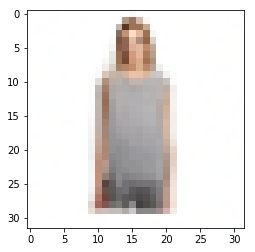

In [18]:
eps3 = eps1 + direction * .5
x_hat = model.decode(y, eps3)

x_hat[0].shape

plt.imshow((x_hat[0]))

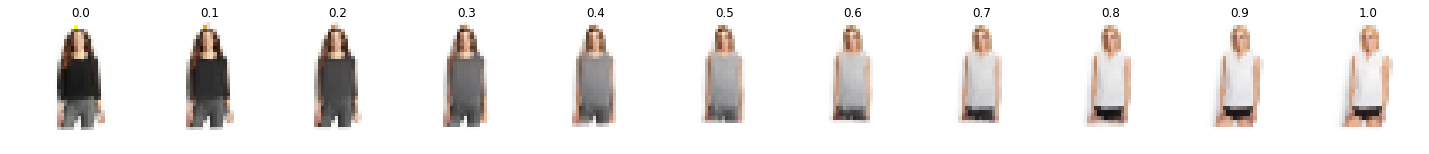

In [19]:
fig, axes = plt.subplots(1, 11, figsize=(25, 5))
for i in range(11):
    eps = eps1 + direction * i/10 
    x_hat = model.decode(y, eps)
    axes[i].set_title('{:.1f}'.format(i*.1))
    axes[i].imshow(x_hat[0])
    axes[i].axis('off')